In [4]:
%matplotlib notebook

## ver1

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap

class SchellingModel:
    def __init__(self, grid_size, n_agents, n_types, similarity_threshold, max_iterations=1000, max_distance=10):
        if n_agents > grid_size * grid_size:
            raise ValueError("Agents cannot exceed the grid size.")
        if not (0 <= similarity_threshold <= 1):
            raise ValueError("Similarity threshold must be between 0 and 1.")
        self.grid_size = grid_size
        self.n_agents = n_agents
        self.n_types = n_types
        self.similarity_threshold = similarity_threshold
        self.max_iterations = max_iterations
        self.max_distance = max_distance  # Maximum distance for movement
        self.grid = np.zeros((grid_size, grid_size), dtype=int)
        self.store = []
        self.agents = []
        self.money = {}  # Dictionary to store money for each agent
        self.grid_costs = np.full((grid_size, grid_size), 100)  # Initialize all grid prices to 100
        self.base_wealth = np.clip(np.random.normal(loc=50, scale=15, size=n_agents), 1, 100)  # Base wealth for agents
        self.economic_centers = [(self.grid_size//2, self.grid_size//2)]  # High-wage areas

    def initialize_grid(self):
        positions = np.random.choice(self.grid_size * self.grid_size, self.n_agents, replace=False)
        for idx, pos in enumerate(positions):
            x, y = divmod(pos, self.grid_size)
            agent_type = np.random.randint(1, self.n_types + 1)
            self.grid[x, y] = agent_type
            self.agents.append((x, y, agent_type))
            self.money[(x, y)] = self.base_wealth[idx]  # Assign base wealth

        # Initialize grid prices based on distance to the center
        center_x, center_y = self.economic_centers[0]
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                distance = 1 + ((x - center_x) * 2 + (y - center_y) * 2)
                self.grid_costs[x, y] += int(distance * 20)  # Increase price based on distance

    def get_neighbors(self, x, y):
        neighbors = []
        for i in range(-1, 2):
            for j in range(-1, 2):
                if i == 0 and j == 0:
                    continue
                nx, ny = x + i, y + j
                if 0 <= nx < self.grid_size and 0 <= ny < self.grid_size:
                    neighbors.append(self.grid[nx, ny])
        return neighbors

    def is_satisfied(self, x, y, agent_type):
        neighbors = self.get_neighbors(x, y)
        if not neighbors:
            return False
        similar_neighbors = sum(1 for n in neighbors if n == agent_type)
        similarity_ratio = similar_neighbors / len(neighbors)
        return similarity_ratio >= self.similarity_threshold

    def update_house_prices(self):
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                if self.grid[x, y] == 0:
                    neighbors = self.get_neighbors(x, y)
                    num_agents = sum(1 for n in neighbors if n != 0)
                    similarity = sum(1 for n in neighbors if n == self.grid[x, y]) / len(neighbors) if neighbors else 0
                    self.grid_costs[x, y] += (num_agents * 2) + (similarity * 10)  # Increase price based on similarity
                    self.grid_costs[x, y] = np.clip(self.grid_costs[x, y], 100, 10000)  # Keep prices within a range

    def update_wages(self):
        for idx, (x, y, _) in enumerate(self.agents):
            self.money[(x, y)] += self.base_wealth[idx] * 0.1  # Update wealth based on base wealth

    def move_agent(self, agent_idx):
        x, y, agent_type = self.agents[agent_idx]
        
        # Check if the agent is unsatisfied
        if not self.is_satisfied(x, y, agent_type):
            # Randomly select a new position within the grid
            new_x, new_y = np.random.randint(0, self.grid_size), np.random.randint(0, self.grid_size)
            
            # Check if the new position is empty and if the agent can afford to move there
            if self.grid[new_x, new_y] == 0 and self.money[(x, y)] >= self.grid_costs[new_x, new_y]:
                # Move the agent to the new position
                self.grid[x, y] = 0
                self.grid[new_x, new_y] = agent_type
                self.agents[agent_idx] = (new_x, new_y, agent_type)
                self.money[(new_x, new_y)] = self.money[(x, y)] - self.grid_costs[new_x, new_y]
                del self.money[(x, y)]

    def run(self):
        self.initialize_grid()
        for iteration in range(self.max_iterations):
            self.store.append(self.grid.copy())
            if iteration % 100 == 0:  # Update grid prices every 500 iterations
                self.update_house_prices()
            if iteration % 5 == 0:  # Update wages every 5 iterations
                self.update_wages()
            np.random.shuffle(self.agents)
            for agent_idx in range(len(self.agents)):
                self.move_agent(agent_idx)
            if all(self.is_satisfied(x, y, agent_type) for x, y, agent_type in self.agents):
                print(f"Converged after {iteration + 1} iterations")
                break
        else:
            print(f"Reached maximum iterations ({self.max_iterations})")
            
    def plot_grid(self):
        # Define a colormap with distinct colors
        cmap = ListedColormap(['white', 'blue', 'red', 'green', 'yellow', 'purple', 'orange'][:self.n_types + 1])
        plt.imshow(self.grid, cmap=cmap, interpolation='none', vmin=0, vmax=self.n_types)
        # Create a legend
        legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='white', markersize=10, label='Empty'),
                           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=10, label='Type 1'),
                           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=10, label='Type 2')]
        plt.legend(handles=legend_elements, loc='upper right')
        plt.show()

    def create_animation(self, save_path=None):
        fig, ax = plt.subplots()
        # Define a colormap with distinct colors
        cmap = ListedColormap(['white', 'blue', 'red', 'green', 'yellow', 'purple', 'orange'][:self.n_types + 1])
        im = ax.imshow(self.store[0], cmap=cmap, interpolation='none', vmin=0, vmax=self.n_types)
        # Create a legend
        legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='white', markersize=10, label='Empty'),
                           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=10, label='Type 1'),
                           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=10, label='Type 2')]
        ax.legend(handles=legend_elements, loc='upper right')
        plt.colorbar(im)

        def update(frame):
            im.set_data(self.store[frame])
            return [im]

        anim = animation.FuncAnimation(
            fig, 
            update, 
            frames=len(self.store), 
            interval=100, 
            blit=True
        )
        display(fig)
        plt.show()

        if save_path:
            try:
                if save_path.endswith('.mp4'):
                    writer = animation.FFMpegWriter(fps=10)  
                    anim.save(save_path, writer=writer)
                elif save_path.endswith('.gif'):
                    writer = animation.PillowWriter(fps=10)  
                    anim.save(save_path, writer=writer)
                else:
                    raise ValueError("Unsupported file format. Use '.mp4' or '.gif'.")
                print(f"Animation saved to {save_path}")
            except Exception as e:
                print(f"Failed to save animation: {e}")



Reached maximum iterations (1000)


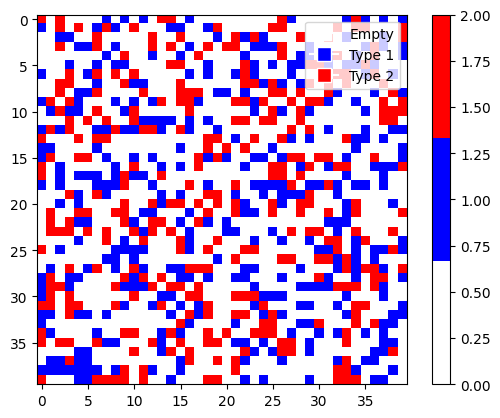

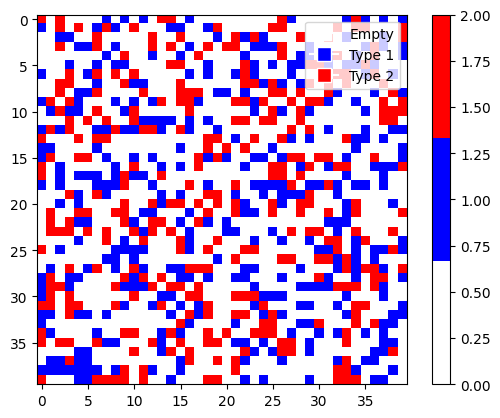

Animation saved to schelling_animationv6.mp4


In [45]:
model = SchellingModel(grid_size=40, n_agents=700, n_types=2, similarity_threshold=0.5)
model.run()
model.create_animation(save_path='schelling_animationv6.mp4')

In [22]:
np.random.normal(20, 10)

27.855196313475005

## ver2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap

class SchellingModel:
    def __init__(self, grid_size, n_agents, n_types, similarity_threshold, max_iterations=1000):
        if n_agents > grid_size * grid_size:
            raise ValueError("Agents cannot exceed the grid size.")
        if not (0 <= similarity_threshold <= 1):
            raise ValueError("Similarity threshold must be between 0 and 1.")
        self.grid_size = grid_size
        self.n_agents = n_agents
        self.n_types = n_types
        self.similarity_threshold = similarity_threshold
        self.max_iterations = max_iterations
        self.grid = np.zeros((grid_size, grid_size), dtype=int)
        self.store = []
        self.agents = []
        self.money = {}  # Dictionary to store money for each agent
        self.grid_costs = np.random.randint(50, 101, size=(grid_size, grid_size))
        self.base_price = 75  # Base price for houses
        self.economic_centers = [(grid_size/2,grid_size/2)]  # High-wage areas

    def initialize_grid(self):
        positions = np.random.choice(self.grid_size * self.grid_size, self.n_agents, replace=False)
        for pos in positions:
            x, y = divmod(pos, self.grid_size)
            agent_type = np.random.randint(1, self.n_types + 1)
            self.grid[x, y] = agent_type
            self.agents.append((x, y, agent_type))
            self.money[(x, y)] = np.clip(np.random.normal(loc=12.5, scale=2.5), 5, 20)

    def get_neighbors(self, x, y):
        neighbors = []
        for i in range(-1, 2):
            for j in range(-1, 2):
                if i == 0 and j == 0:
                    continue
                nx, ny = x + i, y + j
                if 0 <= nx < self.grid_size and 0 <= ny < self.grid_size:
                    neighbors.append(self.grid[nx, ny])
        return neighbors

    def is_satisfied(self, x, y, agent_type):
        neighbors = self.get_neighbors(x, y)
        if not neighbors:
            return False
        similar_neighbors = sum(1 for n in neighbors if n == agent_type)
        similarity_ratio = similar_neighbors / len(neighbors)
        return similarity_ratio >= self.similarity_threshold

    def update_house_prices(self):
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                if self.grid[x, y] == 0:
                    neighbors = self.get_neighbors(x, y)
                    num_agents = sum(1 for n in neighbors if n != 0)
                    num_empty = len(neighbors) - num_agents
                    price = self.base_price + (2 * num_agents) - (1 * num_empty)
                    
                    min_distance = min(np.linalg.norm(np.array([x, y]) - np.array(center)) for center in self.economic_centers) #random noise # the number of people around it 
                    proximity_factor = max(0, 10 - min_distance)  
                    price += proximity_factor * 2  # weight

                    self.grid_costs[x, y] = np.clip(price, 50, 400)

    def update_wages(self):
        for x, y, _ in self.agents:
            distances = [np.sqrt((x - cx) ** 2 + (y - cy) ** 2) for cx, cy in self.economic_centers]
            min_distance = min(distances)
            base_wage = 30 + (min_distance * 3)  # Closer to center = higher wage
            self.money[(x, y)] += base_wage ##np.clip(np.random.normal(base_wage, 5), 5, 400)

    def move_agent(self, agent_idx):
        x, y, agent_type = self.agents[agent_idx]
        
        # Check if the agent is unsatisfied
        if not self.is_satisfied(x, y, agent_type):
            # Find all empty cells
            empty_cells = [(i, j) for i in range(self.grid_size) for j in range(self.grid_size) if self.grid[i, j] == 0]
            
            # Calculate a score for each empty cell based on cost and proximity to same-type agents
            scores = []
            for (new_x, new_y) in empty_cells:
                cost = self.grid_costs[new_x, new_y]
                if self.money[(x, y)] >= cost:  # Ensure the agent can afford the move
                    # Calculate the number of same-type neighbors
                    neighbors = self.get_neighbors(new_x, new_y)
                    same_type_neighbors = sum(1 for n in neighbors if n == agent_type)
                    # Score is a combination of low cost and high same-type neighbors
                    score = -cost + same_type_neighbors * 10  # Weight same-type neighbors more. The number are the weight of how worth is the neighbours.
                    scores.append((new_x, new_y, score))
            
            if scores:
                # Move to the cell with the highest score
                new_x, new_y, _ = max(scores, key=lambda x: x[2])
                self.grid[x, y] = 0
                self.grid[new_x, new_y] = agent_type
                self.agents[agent_idx] = (new_x, new_y, agent_type)
                self.money[(new_x, new_y)] = self.money[(x, y)] - cost
                del self.money[(x, y)]

    def run(self):
        self.initialize_grid()
        for iteration in range(self.max_iterations):
            self.store.append(self.grid.copy())
            self.update_house_prices()
            if iteration % 20 == 0:
                self.update_wages()
            np.random.shuffle(self.agents)
            for agent_idx in range(len(self.agents)):
                self.move_agent(agent_idx)
            if all(self.is_satisfied(x, y, agent_type) for x, y, agent_type in self.agents):
                print(f"Converged after {iteration + 1} iterations")
                break
        else:
            print(f"Reached maximum iterations ({self.max_iterations})")
            
    def plot_grid(self):
        # Define a colormap with distinct colors
        cmap = ListedColormap(['white', 'blue', 'red', 'green', 'yellow', 'purple', 'orange'][:self.n_types + 1])
        plt.imshow(self.grid, cmap=cmap, interpolation='none', vmin=0, vmax=self.n_types)
        # Create a legend
        legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='white', markersize=10, label='Empty'),
                           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=10, label='Type 1'),
                           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=10, label='Type 2')]
        plt.legend(handles=legend_elements, loc='upper right')
        plt.show()

    def create_animation(self, save_path=None):
        fig, ax = plt.subplots()
        # Define a colormap with distinct colors
        cmap = ListedColormap(['white', 'blue', 'red', 'green', 'yellow', 'purple', 'orange'][:self.n_types + 1])
        im = ax.imshow(self.store[0], cmap=cmap, interpolation='none', vmin=0, vmax=self.n_types)
        # Create a legend
        legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='white', markersize=10, label='Empty'),
                           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=10, label='Type 1'),
                           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=10, label='Type 2')]
        ax.legend(handles=legend_elements, loc='upper right')
        plt.colorbar(im)

        def update(frame):
            im.set_data(self.store[frame])
            return [im]

        anim = animation.FuncAnimation(
            fig, 
            update, 
            frames=len(self.store), 
            interval=100, 
            blit=True
        )
        display(fig)
        plt.show()

        if save_path:
            try:
                if save_path.endswith('.mp4'):
                    writer = animation.FFMpegWriter(fps=10)  
                    anim.save(save_path, writer=writer)
                elif save_path.endswith('.gif'):
                    writer = animation.PillowWriter(fps=10)  
                    anim.save(save_path, writer=writer)
                else:
                    raise ValueError("Unsupported file format. Use '.mp4' or '.gif'.")
                print(f"Animation saved to {save_path}")
            except Exception as e:
                print(f"Failed to save animation: {e}")

Reached maximum iterations (1000)


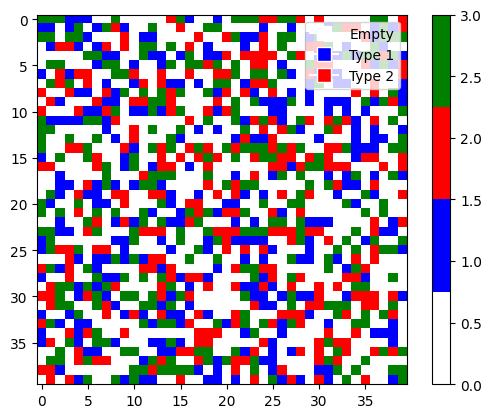

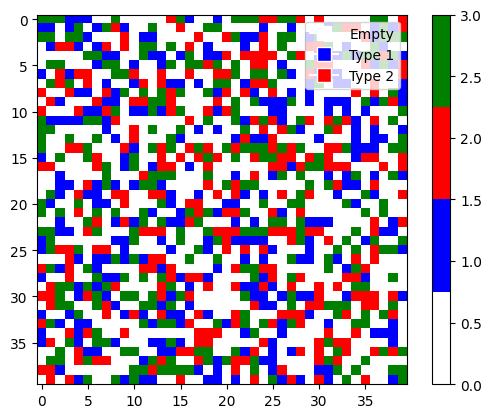

Animation saved to schelling_animationver3.mp4


In [2]:
model = SchellingModel(grid_size=40, n_agents=900, n_types=3, similarity_threshold=0.5)
model.run()
model.create_animation(save_path='schelling_animationver3.mp4')

In [ ]:
sa